In [1]:
import geoai

In [4]:
raster_url = (
    "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train.tif"
)
vector_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train_buildings.geojson"

In [5]:
raster_path = geoai.download_file(raster_url)

naip_train.tif: 100%|██████████| 12.1M/12.1M [00:00<00:00, 21.8MB/s]


In [6]:
vector_path = geoai.download_file(vector_url)

naip_train_buildings.geojson: 100%|██████████| 456k/456k [00:00<00:00, 3.67MB/s]


In [7]:
extractor = geoai.BuildingFootprintExtractor()

Model path not specified, downloading from Hugging Face...


building_footprints_usa.pth:   0%|          | 0.00/176M [00:00<?, ?B/s]

Model downloaded to: /home/zyang91/.cache/huggingface/hub/models--giswqs--geoai/snapshots/75788bf6253e967a91b9576b1620949a3b939820/building_footprints_usa.pth
Model loaded successfully


In [8]:
mask_path = extractor.save_masks_as_geotiff(
    raster_path=raster_path,
    output_path="naip_building_masks.tif",
    confidence_threshold=0.5,
    mask_threshold=0.5,
)

Processing masks with parameters:
- Confidence threshold: 0.5
- Chip size: (512, 512)
- Mask threshold: 0.5
Dataset initialized with 3 rows and 7 columns of chips
Image dimensions: 2503 x 1126 pixels
Chip size: 512 x 512 pixels
Overlap: 25.0% (stride_x=384, stride_y=384)
CRS: EPSG:26911
Processing raster with 6 batches


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

Object masks saved to naip_building_masks.tif


In [9]:
gdf = extractor.masks_to_vector(
    mask_path=mask_path,
    output_path="naip_building_masks.geojson",
    simplify_tolerance=1.0,
)

Converting mask to GeoJSON with parameters:
- Mask threshold: 0.5
- Min object area: 100
- Max object area: None
- Simplify tolerance: 1.0
- NMS IoU threshold: 0.5
- Regularize objects: True
- Angle threshold: 15° from 90°
- Rectangularity threshold: 70.0%
Mask dimensions: (1126, 2503)
Mask value range: 0 to 255
Found 696 potential objects


100%|██████████| 696/696 [00:01<00:00, 575.08it/s]


Created 664 valid polygons
Object count after NMS filtering: 664
Regularizing 664 objects...
- Angle threshold: 15° from 90°
- Min orthogonality: 30.0% of angles
- Min rectangularity: 70.0% of bounding box area


100%|██████████| 664/664 [00:00<00:00, 2126.62it/s]

Regularization completed:
- Total objects: 664
- Rectangular objects: 660 (99.4%)
- Other regularized objects: 0 (0.0%)
- Unmodified objects: 4 (0.6%)
Saved 664 objects to naip_building_masks.geojson


In [10]:
output_path = "naip_building_masks.geojson"
gdf = extractor.process_raster(
    raster_path,
    output_path="buildings.geojson",
    confidence_threshold=0.5,
    batch_size=4,
    overlap=0.25,
    nms_iou_threshold=0.5,
    small_building_area=100,
    mask_threshold=0.5,
    simplify_tolerance=1.0,
)

Processing with parameters:
- Confidence threshold: 0.5
- Tile overlap: 0.25
- Chip size: (512, 512)
- NMS IoU threshold: 0.5
- Mask threshold: 0.5
- Min object area: 100
- Max object area: None
- Simplify tolerance: 1.0
- Filter edge objects: True
- Edge buffer size: 20 pixels
Dataset initialized with 3 rows and 7 columns of chips
Image dimensions: 2503 x 1126 pixels
Chip size: 512 x 512 pixels
Overlap: 25.0% (stride_x=384, stride_y=384)
CRS: EPSG:26911
Processing raster with 6 batches


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Objects before filtering: 749
Objects after filtering: 749
Saved 749 objects to buildings.geojson


In [11]:
gdf_regularized = extractor.regularize_buildings(
    gdf=gdf,
    min_area=100,
    angle_threshold=15.0,
    orthogonality_threshold=0.3,
    rectangularity_threshold=0.7,
)

Regularizing 749 objects...
- Angle threshold: 15.0° from 90°
- Min orthogonality: 30.0% of angles
- Min rectangularity: 70.0% of bounding box area


100%|██████████| 749/749 [00:00<00:00, 2307.04it/s]

Regularization completed:
- Total objects: 749
- Rectangular objects: 695 (92.8%)
- Other regularized objects: 0 (0.0%)
- Unmodified objects: 54 (7.2%)


In [12]:
gdf.head()

geometry  confidence  class
549   POLYGON ((455272.2 5277763.2, 455271 5277762, ...    0.999945      1
1236  POLYGON ((455984.4 5277643.8, 455983.8 5277643...    0.999941      1
889   POLYGON ((456074.4 5277719.4, 456073.2 5277718...    0.999941      1
550   POLYGON ((455243.4 5277855, 455242.8 5277854.4...    0.999938      1
439   POLYGON ((454989 5277799.2, 454988.4 5277798.6...    0.999931      1

In [25]:
geoai.view_vector_interactive(
    gdf, column="confidence", layer_name="Building", tiles="Satellite"
)

In [24]:
import leafmap

m = leafmap.Map()

# Add the GeoDataFrame layer
m.add_gdf(gdf, layer_name="Buildings", style={"color": "red", "weight": 2})

centroid = gdf.to_crs(4326).geometry.unary_union.centroid
m.set_center(centroid.x, centroid.y, zoom=15)

m.add_basemap("SATELLITE")

# Display the map
m

Map(center=[47.65274473826974, -117.59106594847381], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [26]:
geoai.view_vector_interactive(
    gdf, column="confidence", layer_name="Building", tiles=raster_url
)

In [27]:
geoai.view_vector_interactive(
    gdf_regularized, column="confidence", layer_name="Building", tiles=raster_url
)

Using confidence values (range: 0.57 - 1.00)
Visualization saved to naip_buildings.png
Sample visualization saved to naip_buildings_sample.png


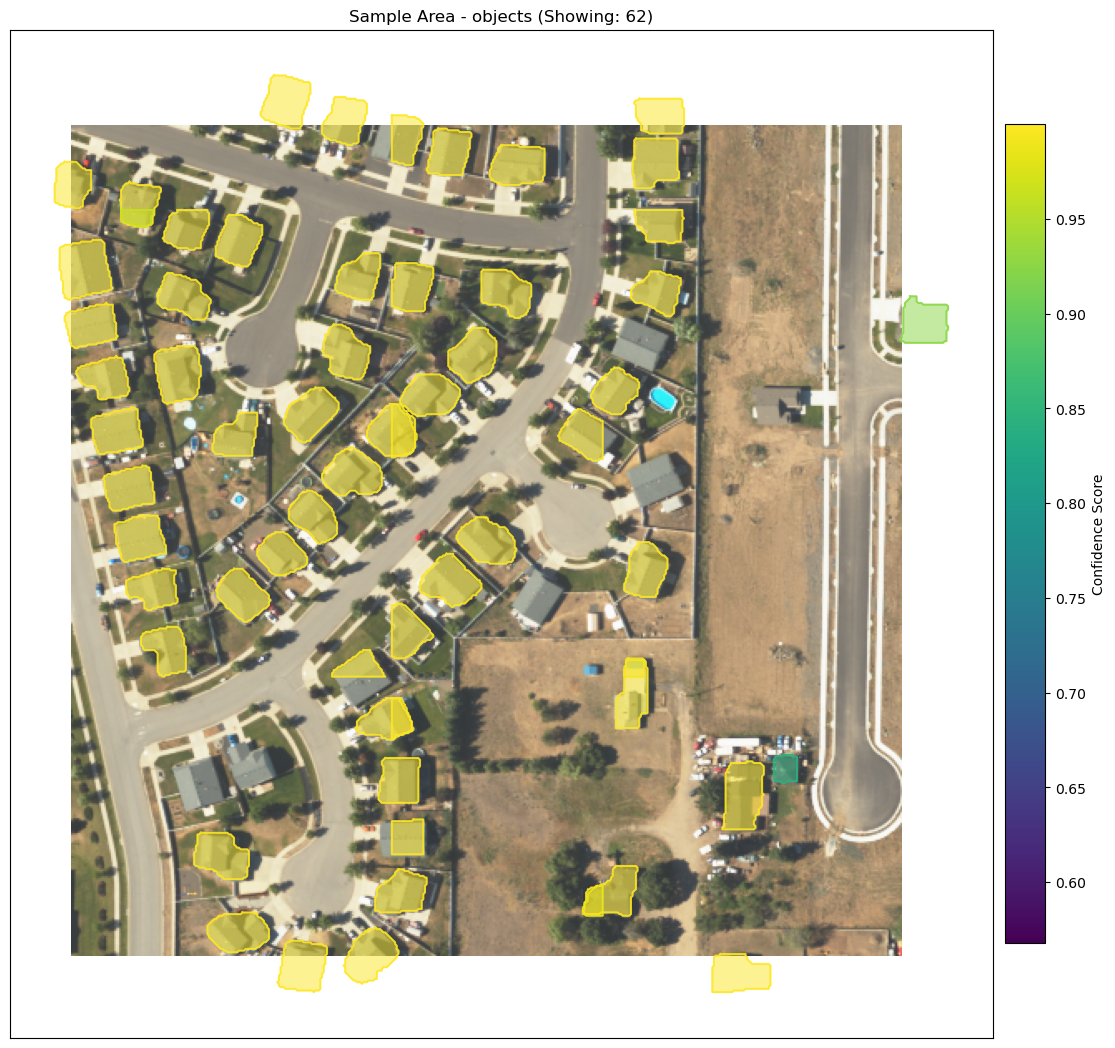

In [28]:
extractor.visualize_results(raster_path, gdf, output_path="naip_buildings.png")

Using confidence values (range: 0.57 - 1.00)
Visualization saved to naip_buildings_regularized.png
Sample visualization saved to naip_buildings_regularized_sample.png


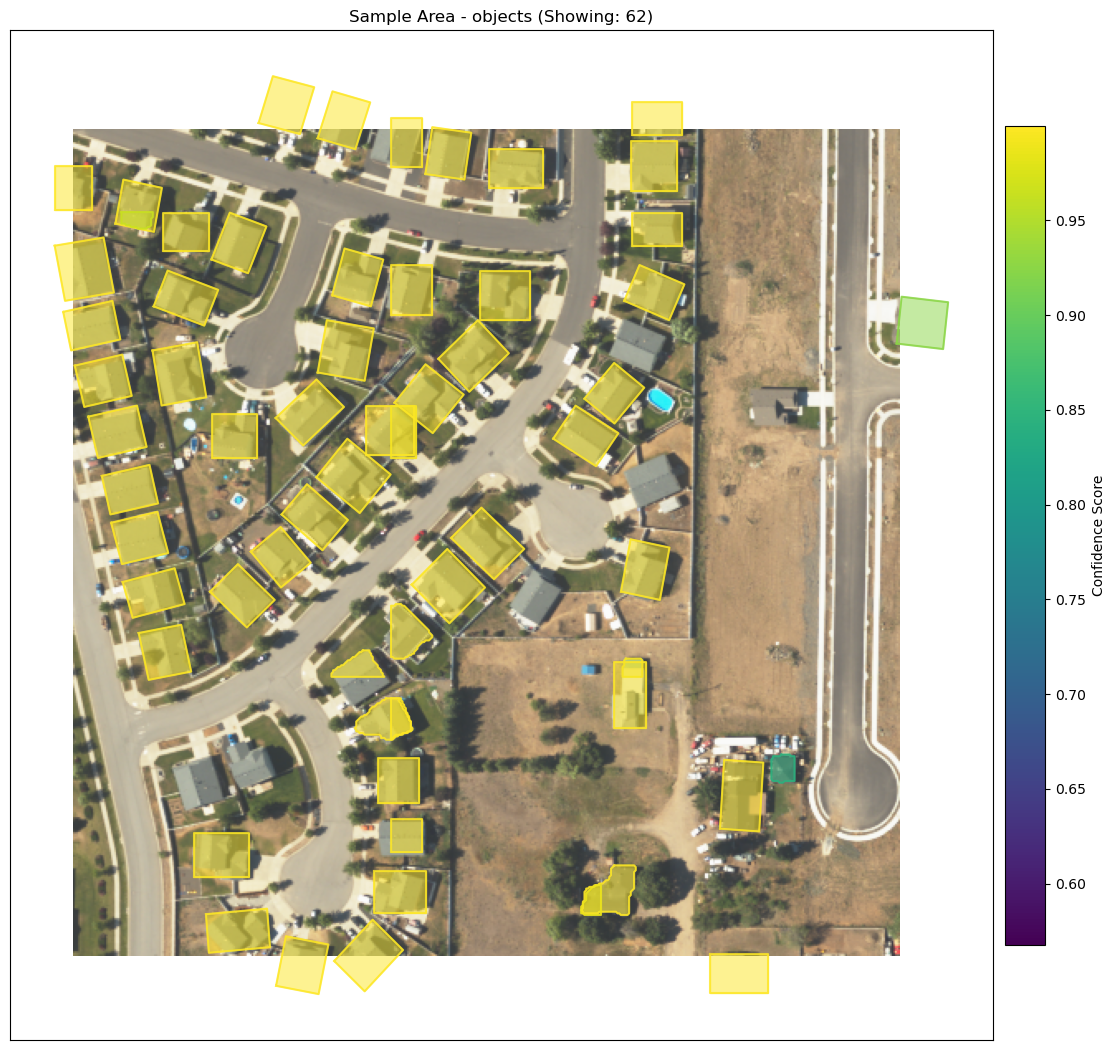

In [29]:
extractor.visualize_results(
    raster_path, gdf_regularized, output_path="naip_buildings_regularized.png"
)